### Zespół 4:
- Jakub Smuga
- Konrad Korus
- Maksym Kazhaiev

## Wstęp Teoretyczny do Metod XAI: Sobol i PAWN

### Analiza Sobola
https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis
Jest to metoda globalnej analizy czułości, która ocenia, w jakim stopniu zmienność w wyjściu modelu może być przypisana do zmienności poszczególnych wejść modelu.

Podstawowe koncepcje:

1. Rozkład wariancji: Analiza Sobola polega na dekompozycji całkowitej wariancji wyjścia modelu na wkłady poszczególnych zmiennych wejściowych oraz ich interakcje.

2. Indeksy Sobola: Są to miary czułości, które określają, w jakim stopniu dana zmienna wejściowa wpływa na zmienność wyjścia. Wyróżniamy:
  - Pierwszego rzędu indeks Sobola (Si): Mierzy bezpośredni wpływ zmiennej wejściowej na wyjście modelu.
  - Drugiego rzędu indeks Sobola (Sij): Mierzy wpływ interakcji między dwiema zmiennymi wejściowymi na wyjście modelu.
  - Całkowity indeks Sobola (STi): Mierzy całkowity wpływ danej zmiennej, włączając w to jej interakcje z innymi zmiennymi.

Zalety:
- Dokładność w identyfikacji wpływu zmiennych.
- Możliwość oceny zarówno efektów głównych, jak i interakcji.

Wady:
- Wysokie wymagania obliczeniowe, zwłaszcza dla modeli z dużą liczbą zmiennych wejściowych.
- Złożoność implementacji w przypadku nieliniowych i wysokowymiarowych modeli.

### Analiza Pawn
https://www.sciencedirect.com/science/article/pii/S1364815219306607
Analiza PAWN (Partial WAveform NOise) jest stosunkowo nową metodą globalnej analizy czułości, która została zaprojektowana z myślą o uproszczeniu i poprawie efektywności obliczeniowej w porównaniu do tradycyjnych metod, takich jak analiza Sobola.

Podstawowe koncepcje:

1. Kondycjonowanie rozkładów wyjściowych: Metoda PAWN polega na analizie rozkładów wyjściowych modelu, które są kondycjonowane na różne wartości zmiennych wejściowych. Kondycjonowanie - normalizacja, standaryzacja czy inne formy przekształcania danych, które pomagają poprawić jakość wyników analizy.

2. Miara czułości: PAWN używa miary bazującej na odległości między rozkładami (np. odległość Kolmogorowa-Smirnowa), aby ocenić wpływ zmiennych wejściowych na wyjście modelu.

Zalety:

- Mniejsze wymagania obliczeniowe w porównaniu do analizy Sobola.
- Prostota implementacji.
- Skuteczność w identyfikacji kluczowych zmiennych wejściowych.

Wady:
- Może być mniej precyzyjna w identyfikacji złożonych interakcji między zmiennymi wejściowymi.
- Wrażliwość na wybór miar odległości i parametrów kondycjonowania.

### Porównanie metod Sobol i PAWN
- Dokładność: Analiza Sobola jest bardziej precyzyjna w identyfikacji wpływu poszczególnych zmiennych oraz ich interakcji, jednak jest to okupione większymi wymaganiami obliczeniowymi.
- Wydajność: Analiza PAWN jest bardziej efektywna obliczeniowo i prostsza w implementacji, ale może być mniej dokładna w przypadkach złożonych zależności między zmiennymi.
- Zastosowania: Analiza Sobola jest bardziej odpowiednia dla modeli wymagających precyzyjnej dekompozycji wariancji, podczas gdy analiza PAWN sprawdza się lepiej w szybkiej ocenie wpływu zmiennych wejściowych w mniej złożonych scenariuszach.

## Imports



In [ ]:
!pip install SALib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from SALib.analyze import pawn
from SALib.sample import saltelli
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt

In [ ]:
from enum import Enum

class AnalysisMethod(Enum):
    SOBOL = "Sobol"
    PAWN = "Pawn"

## Helper functions

In [ ]:
random_shuffle_state = 2024

def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p + valid_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
def plot_accuracy(removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(train_accuracy_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, train_accuracy_history, marker='o', linestyle='-', color='b', label='Train Accuracy')
    plt.plot(removed_inputs_history, valid_accuracy_history, marker='s', linestyle='-', color='g', label='Validation Accuracy')
    plt.plot(removed_inputs_history, test_accuracy_history, marker='^', linestyle='-', color='r', label='Test Accuracy')

    plt.xlabel('Removed Input History')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_time(removed_inputs_history, time_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(time_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, time_history, label='Time')

    plt.xlabel('Removed Input History')
    plt.ylabel('Time')
    plt.title('Time during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_analysis(removed_inputs_history, analysis_history, average_analysis_history, label):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(analysis_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, analysis_history, label=f"{label} analysis value for removed neuron")
    plt.plot(removed_inputs_history, average_analysis_history, label=f"{label} Average analysis value")

    plt.xlabel('Removed Input History')
    plt.ylabel('Analysis')
    plt.title(f'{label} Analysis during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))

##First Layer

In [ ]:
# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def trainAndGetLowestAnalysisValueForFirstLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor,  X_test_tensor, y_test_tensor, analysis_method, columns):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars':  X_train_tensor.shape[1],
        'names': [f'x{i+1}' for i in range( X_train_tensor.shape[1])],
        'bounds': [[0, 1]] *  X_train_tensor.shape[1]
    }

    learning_time_start = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(X_train_tensor)
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(X_valid_tensor)
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, , Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} (column: {columns[min_sobol_index]}) |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} (column: {columns[min_pawn_index]}) |  PAWN value =  {Si['CV'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['CV'][min_pawn_index], avarage_value

                else:
                  print("Wrong analysis method!")


def trainWhileRemovingInputsBasedOnAnalysisForFirstLayer (X, y, hiddden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(len(X.columns)):
        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForFirstLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, analysis_method, X.columns)
        removed_inputs_history.append(X.columns[removed_input])
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        X = X.drop(X.columns[removed_input], axis=1)
        print("")


    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Second Layer


In [ ]:
# Definicja modelu MLP
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def trainAndGetLowestAnalysisValueForSecondLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, dim, analysis_method):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars': dim,
        'names': [i for i in range(dim)],
        'bounds': [[0, 1]] * dim
    }

    bounds = np.array([[0, 1]] * dim)

    learning_time_start = time.time()
    for epoch in range(epochs):

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = model.relu(model.fc1(X_train_tensor[i:i+batch_size]))
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(model.relu(model.fc1(X_train_tensor)))
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(model.relu(model.fc1(X_valid_tensor)))
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(model.relu(model.fc1(X_test_tensor)))
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)


            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} |  PAWN value =  {Si['median'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, min_pawn_index, avarage_value

                else:
                  print("Wrong analysis method!")

def trainWhileRemovingInputsBasedOnAnalysisForSecondLayer (X, y, hidden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(hidden_dim):

        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP2(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForSecondLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, hidden_dim, analysis_method)
        removed_inputs_history.append(removed_input)
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        hidden_dim -= 1
        print("")

    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Usuwanie neuronów z pierwszej warstwy - SOBOL

In [ ]:
data = pd.read_csv('banana_quality.csv')

X = data.drop('Quality', axis=1)
y = data['Quality']
hidden_dim = 32

removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol, time_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.0384, Training Accuracy: 0.9796, Valid Accuracy: 0.9725, , Test Accuracy: 0.9708
[Sobol] Dropping neuron with index 5 (column: Ripeness) |  Sobol value =  0.01393 | Avg Sobol value: 0.93122

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.1444, Training Accuracy: 0.9598, Valid Accuracy: 0.9550, , Test Accuracy: 0.9517
[Sobol] Dropping neuron with index 5 (column: Acidity) |  Sobol value =  0.03157 | Avg Sobol value: 0.82430

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.2315, Training Accuracy: 0.9296, Valid Accuracy: 0.9263, , Test Accuracy: 0.9213
[Sobol] Dropping neuron with index 3 (column: Softness) |  Sobol value =  -0.25212 | Avg Sobol value: 0.67925

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.3489, Training Accu

removed_inputs_history:
['Ripeness', 'Acidity', 'Softness', 'HarvestTime', 'Weight', 'Sweetness', 'Size']
train_accuracy_history:
[0.9795833333333334, 0.9597916666666667, 0.9295833333333333, 0.88, 0.8485416666666666, 0.799375, 0.644375]
valid_accuracy_history:
[0.9725, 0.955, 0.92625, 0.86375, 0.82625, 0.785, 0.65625]
test_accuracy_history:
[0.9708333333333333, 0.9516666666666667, 0.92125, 0.87625, 0.8370833333333333, 0.78875, 0.6283333333333333]
time_history:
[5.7097487449646, 6.120718955993652, 3.481013774871826, 2.0028305053710938, 1.856076717376709, 1.7796039581298828, 1.803471565246582]


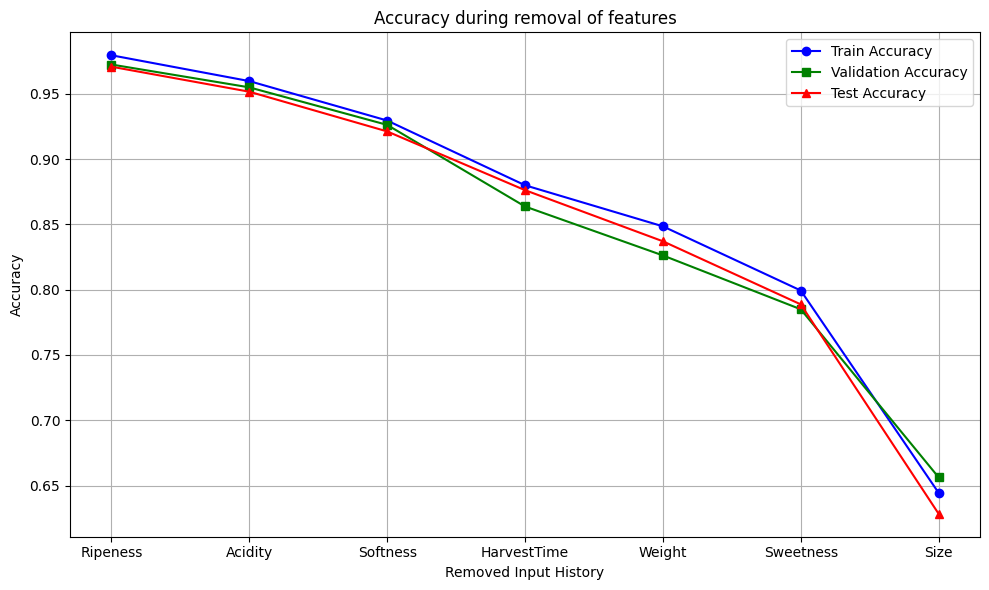

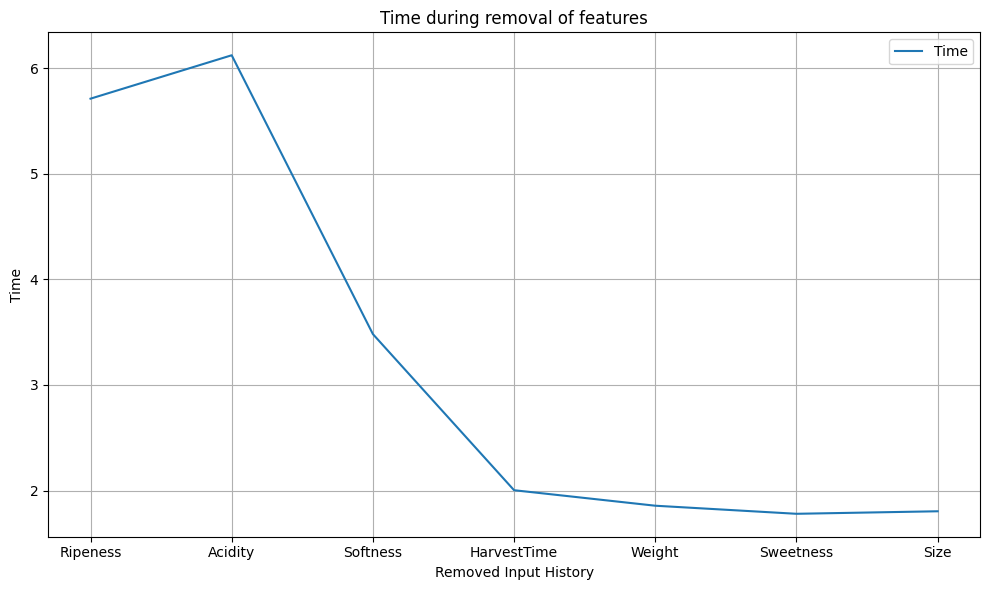

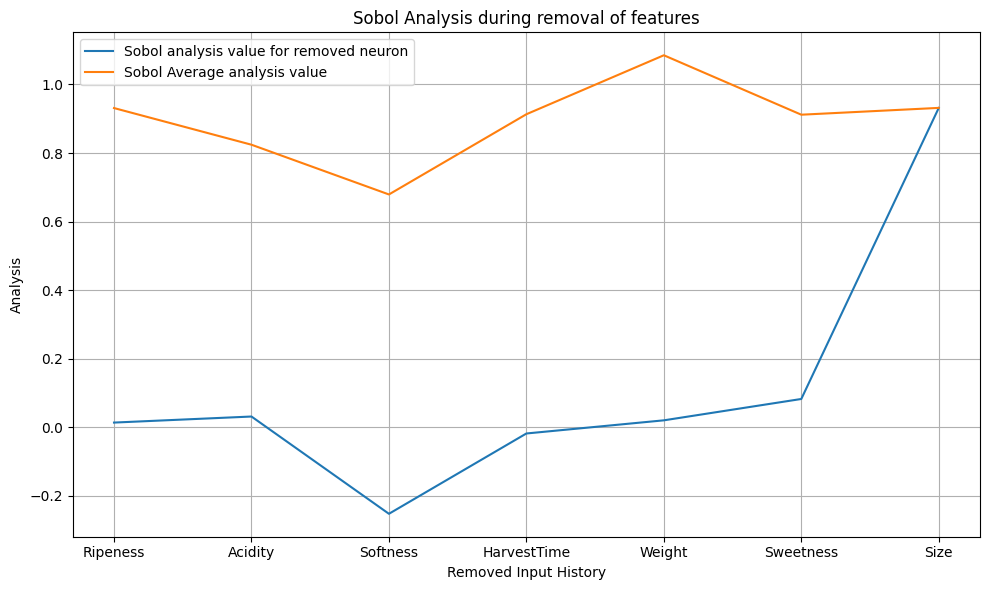

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_first_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_first_sobol)
print("time_history:")
print(time_history_first_sobol)
plot_accuracy(removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol)
plot_time(removed_inputs_history_first_sobol, time_history_first_sobol)
plot_analysis(removed_inputs_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol, "Sobol")

# Usuwanie neuronów z drugiej warstwy - SOBOL


In [ ]:
data = pd.read_csv('banana_quality.csv')

X = data.drop('Quality', axis=1)

#droping useless inputs -example
X = X.drop('Ripeness', axis=1)
X = X.drop('Acidity', axis=1)

y = data['Quality']

hidden_dim = 32


removed_inputs_history_second_sobol, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol, time_history_second_sobol, analysis_history_second_sobol, average_analysis_history_second_sobol = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.2285, Training Accuracy: 0.9304, Valid Accuracy: 0.9300, Test Accuracy: 0.9237
[Sobol] Dropping neuron with index 25 |  Sobol value =  0.00052 | Avg Sobol value: 1.02151

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.2389, Training Accuracy: 0.9333, Valid Accuracy: 0.9287, Test Accuracy: 0.9258
[Sobol] Dropping neuron with index 15 |  Sobol value =  -0.00065 | Avg Sobol value: 1.06936

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.2102, Training Accuracy: 0.9333, Valid Accuracy: 0.9313, Test Accuracy: 0.9287
[Sobol] Dropping neuron with index 23 |  Sobol value =  -0.01339 | Avg Sobol value: 0.90655

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.2231, Training Accuracy: 0.9360, Valid Accuracy: 0.9300, Test Accuracy: 0.927

removed_inputs_history:
[25, 15, 23, 5, 21, 1, 23, 7, 1, 1, 5, 7, 15, 7, 5, 9, 7, 13, 5, 9, 5, 1, 9, 3, 5, 5, 3, 3, 3, 1, 1, 0]
train_accuracy_history:
[0.9304166666666667, 0.9333333333333333, 0.9333333333333333, 0.9360416666666667, 0.9302083333333333, 0.9270833333333334, 0.93, 0.9283333333333333, 0.9295833333333333, 0.92875, 0.923125, 0.925625, 0.9272916666666666, 0.9289583333333333, 0.9247916666666667, 0.924375, 0.9247916666666667, 0.9270833333333334, 0.9233333333333333, 0.9220833333333334, 0.921875, 0.923125, 0.9204166666666667, 0.9122916666666666, 0.9152083333333333, 0.92, 0.911875, 0.9054166666666666, 0.9141666666666667, 0.9054166666666666, 0.9060416666666666, 0.5020833333333333]
valid_accuracy_history:
[0.93, 0.92875, 0.93125, 0.93, 0.9325, 0.93125, 0.92875, 0.92625, 0.92625, 0.92875, 0.925, 0.92125, 0.93125, 0.92625, 0.92625, 0.92875, 0.92625, 0.92625, 0.92, 0.91625, 0.92375, 0.93, 0.9225, 0.90875, 0.91125, 0.92375, 0.915, 0.89, 0.90375, 0.89625, 0.90125, 0.49]
test_accuracy_his

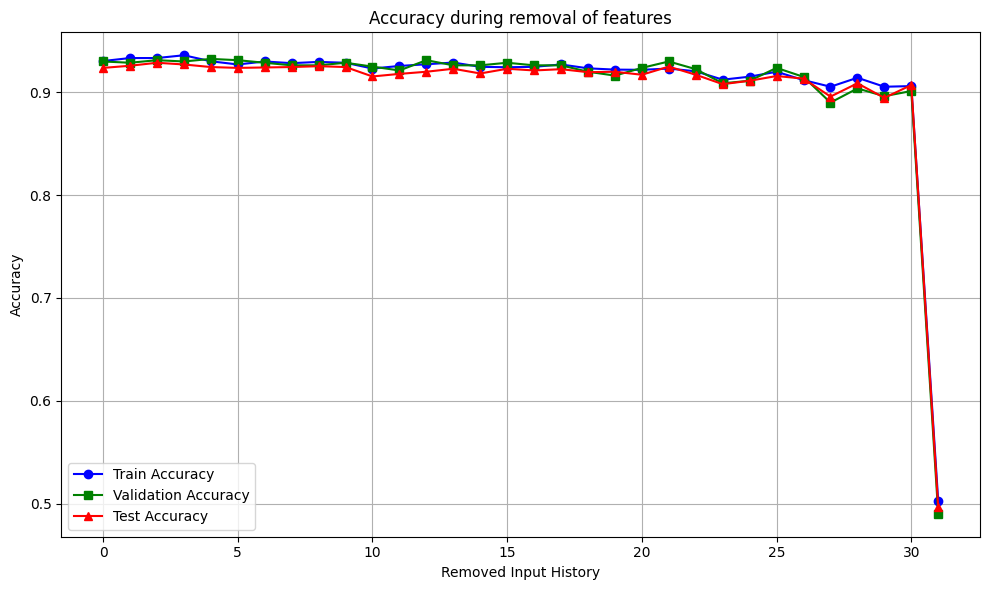

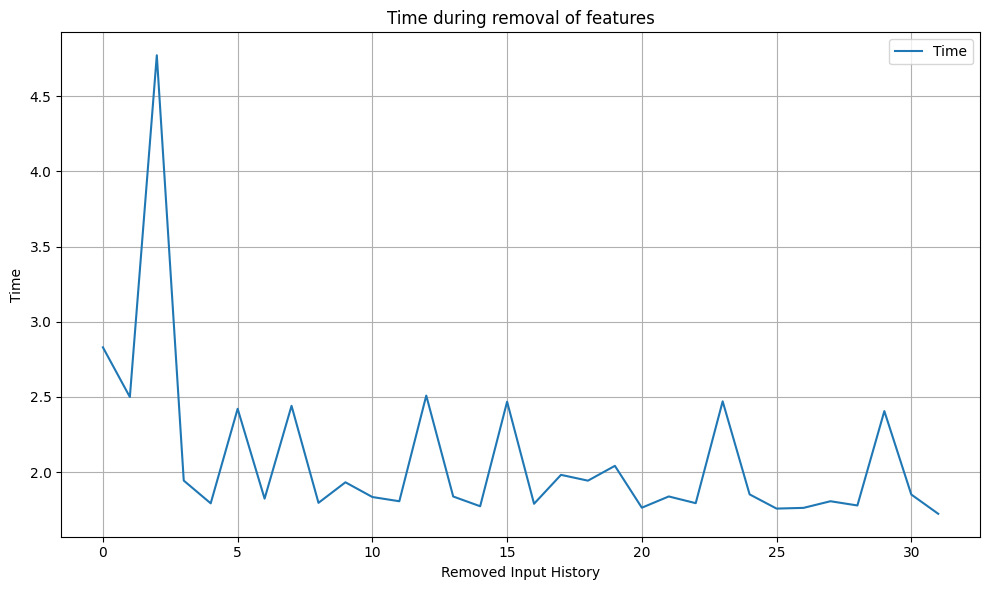

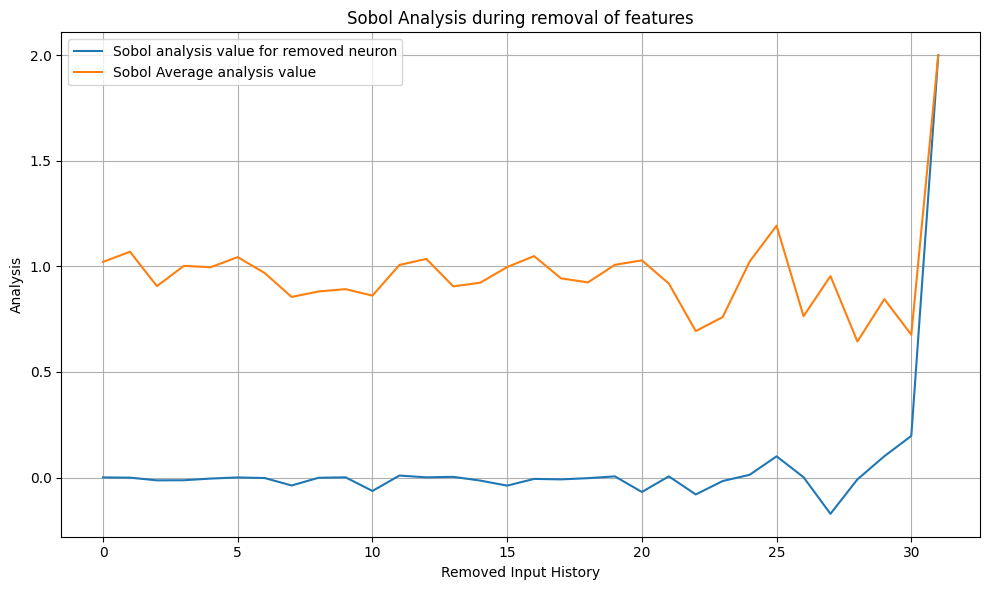

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_second_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_second_sobol)
print("time_history:")
print(time_history_second_sobol)
plot_accuracy(None, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol)
plot_time(None, time_history_second_sobol)
plot_analysis(None, analysis_history_second_sobol, average_analysis_history_second_sobol, "Sobol")

# Usuwanie neuronów z pierwszej warstwy - PAWN

In [ ]:
data = pd.read_csv('banana_quality.csv')

X = data.drop('Quality', axis=1)
y = data['Quality']
hidden_dim = 32

removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn, time_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.0561, Training Accuracy: 0.9748, Valid Accuracy: 0.9688, , Test Accuracy: 0.9688
[PAWN] Dropping neuron with index 3 (column: Softness) |  PAWN value =  0.62980 | Avg PAWN value: 0.11582 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.1844, Training Accuracy: 0.9410, Valid Accuracy: 0.9313, , Test Accuracy: 0.9392
[PAWN] Dropping neuron with index 5 (column: Acidity) |  PAWN value =  0.86184 | Avg PAWN value: 0.02166 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.2383, Training Accuracy: 0.9229, Valid Accuracy: 0.9175, , Test Accuracy: 0.9254
[PAWN] Dropping neuron with index 0 (column: Size) |  PAWN value =  0.76369 | Avg PAWN value: 0.01495 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.3065, Training Accuracy: 0.902

removed_inputs_history:
['Softness', 'Acidity', 'Size', 'Sweetness', 'Ripeness', 'Weight', 'HarvestTime']
train_accuracy_history:
[0.9747916666666666, 0.9410416666666667, 0.9229166666666667, 0.9020833333333333, 0.845, 0.7895833333333333, 0.639375]
valid_accuracy_history:
[0.96875, 0.93125, 0.9175, 0.9, 0.81875, 0.77, 0.62625]
test_accuracy_history:
[0.96875, 0.9391666666666667, 0.9254166666666667, 0.8954166666666666, 0.8425, 0.7804166666666666, 0.6175]
time_history:
[1.8446025848388672, 1.7995858192443848, 1.7741119861602783, 1.8099770545959473, 2.0367588996887207, 2.534252643585205, 1.7994658946990967]


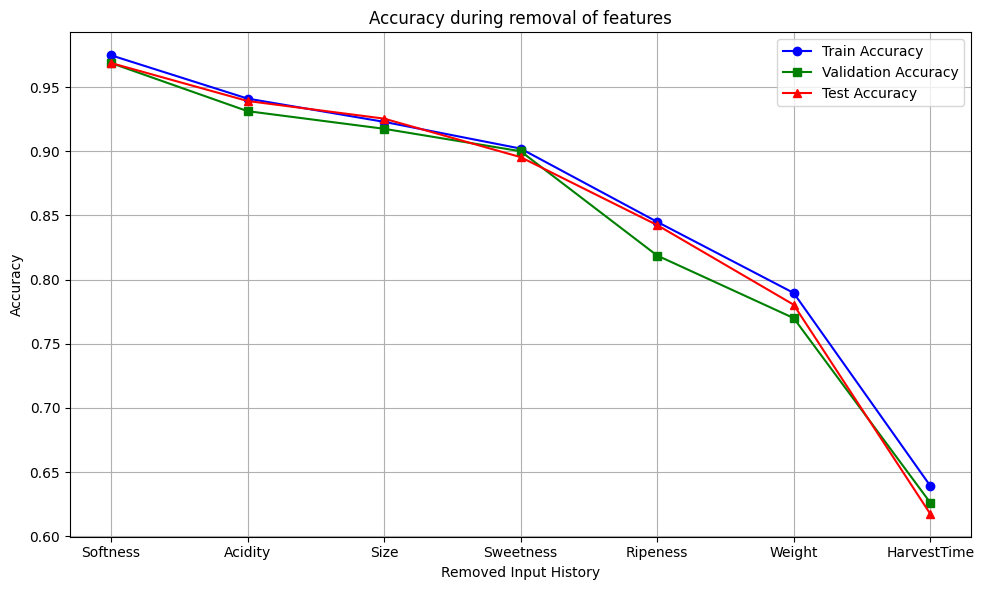

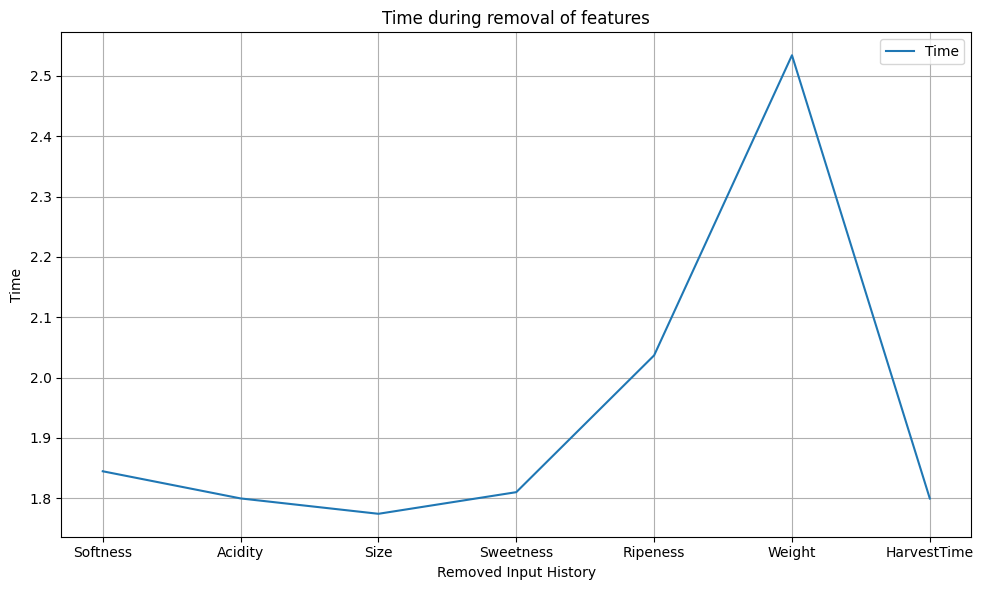

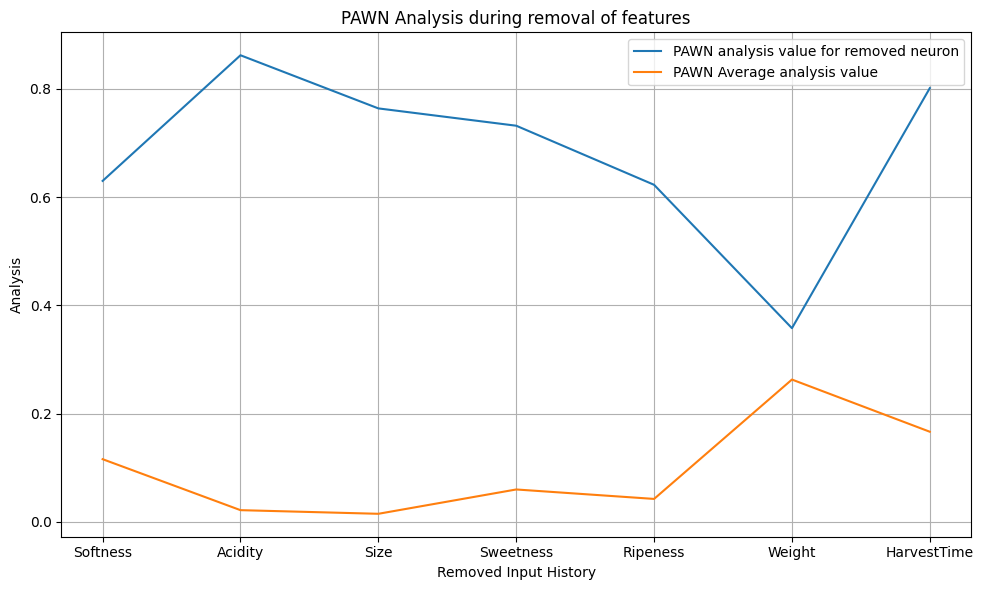

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_first_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_first_pawn)
print("time_history:")
print(time_history_first_pawn)
plot_accuracy(removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn)
plot_time(removed_inputs_history_first_pawn, time_history_first_pawn)
plot_analysis(removed_inputs_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn, "PAWN")

# Usuwanie neuronów z drugiej warstwy - PAWN

In [ ]:
data = pd.read_csv('banana_quality.csv')

X = data.drop('Quality', axis=1)
y = data['Quality']
hidden_dim =32


#droping useless inputs -example
X = X.drop('Sweetness', axis=1)
X = X.drop('Ripeness', axis=1)


removed_inputs_history_second_pawn, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn, time_history_second_pawn, analysis_history_second_pawn, average_analysis_history_second_pawn = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.2347, Training Accuracy: 0.9485, Valid Accuracy: 0.9425, Test Accuracy: 0.9437
[PAWN] Dropping neuron with index 18 |  PAWN value =  0.00566 | Avg PAWN value: 0.02385 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.2742, Training Accuracy: 0.9463, Valid Accuracy: 0.9337, Test Accuracy: 0.9396
[PAWN] Dropping neuron with index 24 |  PAWN value =  0.00856 | Avg PAWN value: 0.03004 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.2405, Training Accuracy: 0.9494, Valid Accuracy: 0.9363, Test Accuracy: 0.9471
[PAWN] Dropping neuron with index 28 |  PAWN value =  0.00999 | Avg PAWN value: 0.02548 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.2739, Training Accuracy: 0.9469, Valid Accuracy: 0.9363, Test Accuracy: 0.9392
[PAWN]

removed_inputs_history:
[18, 24, 28, 26, 12, 11, 16, 18, 16, 6, 21, 6, 14, 17, 4, 7, 12, 9, 9, 8, 6, 7, 6, 0, 1, 0, 4, 2, 1, 0, 1, 0]
train_accuracy_history:
[0.9485416666666666, 0.94625, 0.949375, 0.946875, 0.9460416666666667, 0.9470833333333334, 0.9475, 0.95, 0.9454166666666667, 0.945625, 0.9454166666666667, 0.9402083333333333, 0.944375, 0.9464583333333333, 0.9425, 0.94, 0.943125, 0.9414583333333333, 0.938125, 0.9377083333333334, 0.9389583333333333, 0.9370833333333334, 0.9372916666666666, 0.9379166666666666, 0.9364583333333333, 0.9339583333333333, 0.9279166666666666, 0.9395833333333333, 0.92625, 0.9039583333333333, 0.8408333333333333, 0.7977083333333334]
valid_accuracy_history:
[0.9425, 0.93375, 0.93625, 0.93625, 0.93375, 0.93625, 0.93875, 0.93625, 0.9375, 0.93625, 0.9325, 0.93, 0.93125, 0.93625, 0.9325, 0.93, 0.93125, 0.925, 0.92625, 0.92, 0.92875, 0.92625, 0.92875, 0.92, 0.91875, 0.91875, 0.92625, 0.9325, 0.91875, 0.89875, 0.83, 0.77375]
test_accuracy_history:
[0.94375, 0.939583333

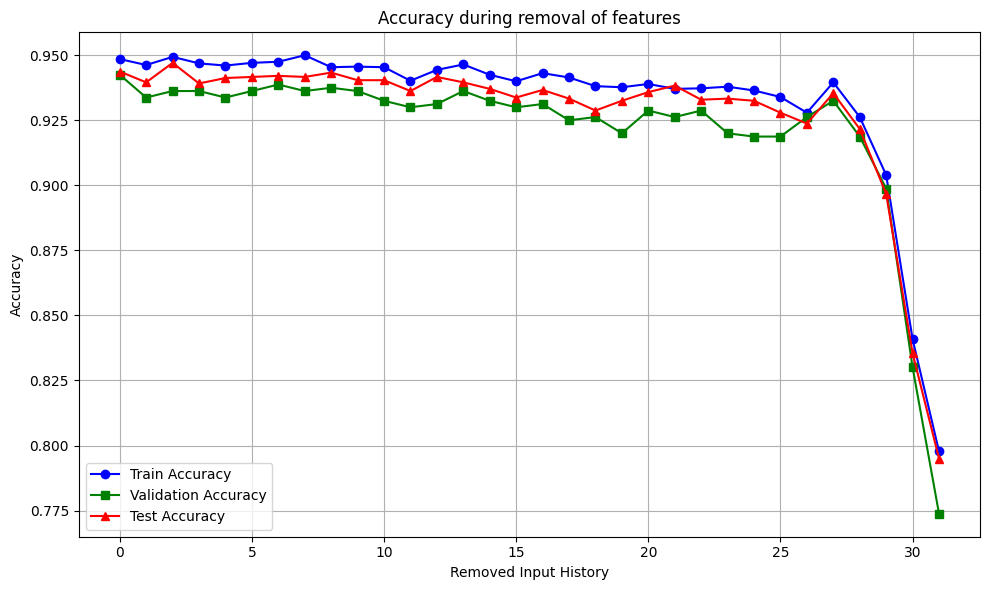

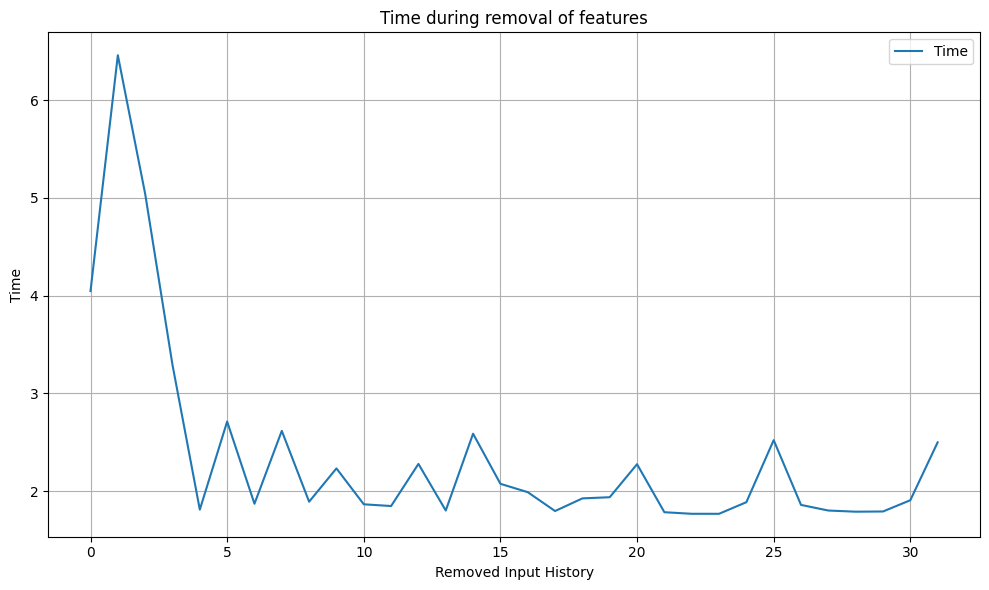

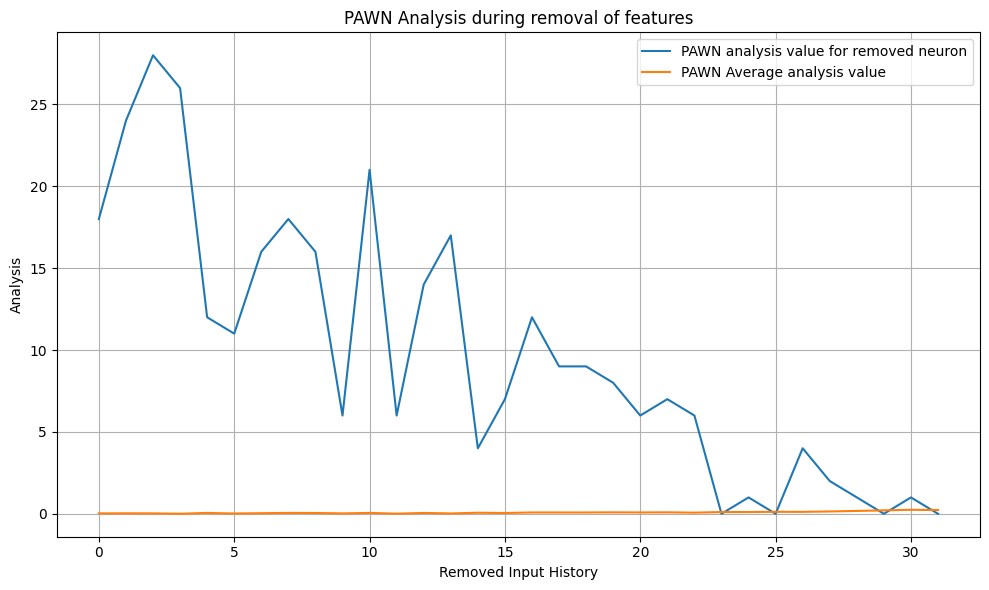

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_second_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_second_pawn)
print("time_history:")
print(time_history_second_pawn)
plot_accuracy(None, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn)
plot_time(None, time_history_second_pawn)
plot_analysis(None, analysis_history_second_pawn, average_analysis_history_second_pawn, "PAWN")